In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1269.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1385.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1383.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1354.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1339.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1380.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1304.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1340.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1211.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1355.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1222.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1

# Necessary Libraries

In [2]:
import os
import csv
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import LeakyReLU, ELU

2024-09-13 14:13:18.859030: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 14:13:18.859155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 14:13:18.994063: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset Loading

In [3]:
# Define image size and paths
IMG_SIZE = 224
DATA_DIR = '/kaggle/input/vegetable-image-dataset/Vegetable Images/'

In [4]:
# Load dataset
def load_dataset(data_dir, img_size):
    images = []
    labels = []
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            image = cv2.imread(file_path)
            image = cv2.resize(image, (img_size, img_size))
            images.append(image)
            labels.append(folder)
    images = np.array(images, dtype='float32') / 255.0
    labels = np.array(labels)
    return images, labels


In [5]:
train_images, train_labels = load_dataset(os.path.join(DATA_DIR, 'train'), IMG_SIZE)
val_images, val_labels = load_dataset(os.path.join(DATA_DIR, 'validation'), IMG_SIZE)
test_images, test_labels = load_dataset(os.path.join(DATA_DIR, 'test'), IMG_SIZE)

# Convert labels to one-hot encoding
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
val_labels = lb.transform(val_labels)
test_labels = lb.transform(test_labels)
print("Successfully loaded all files!!!")

Successfully loaded all files!!!


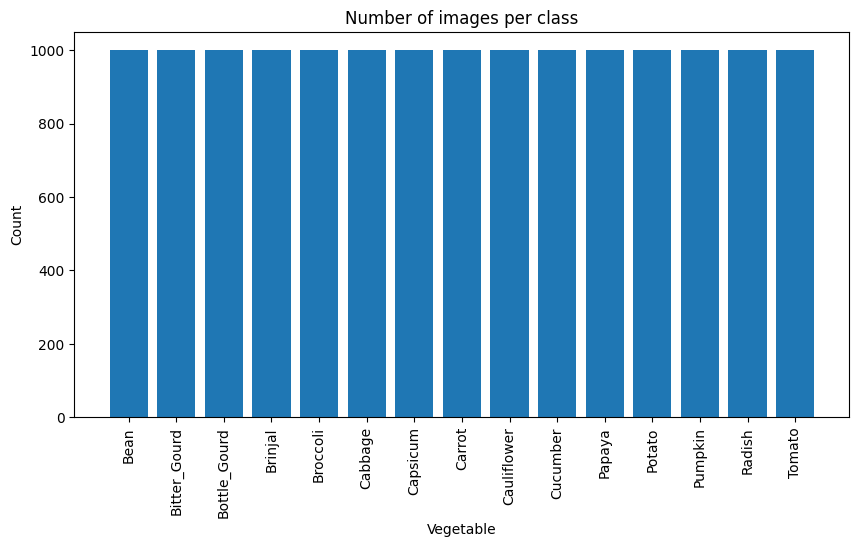

In [6]:
def plot_histogram(images, labels, lb):
    label_names = lb.classes_
    label_counts = np.sum(labels, axis=0)
    plt.figure(figsize=(10, 5))
    plt.bar(label_names, label_counts)
    plt.xlabel('Vegetable')
    plt.ylabel('Count')
    plt.title('Number of images per class')
    plt.xticks(rotation=90)
    plt.show()

plot_histogram(train_images, train_labels, lb)

In [7]:
# def plot_correlation_matrix(images, labels):
#     flat_images = images.reshape(images.shape[0], -1)
#     corr_matrix = np.corrcoef(flat_images)
#     plt.figure(figsize=(10, 10))
#     sns.heatmap(corr_matrix, cmap='viridis')
#     plt.title('Correlation Matrix')
#     plt.show()

# plot_correlation_matrix(train_images, train_labels)

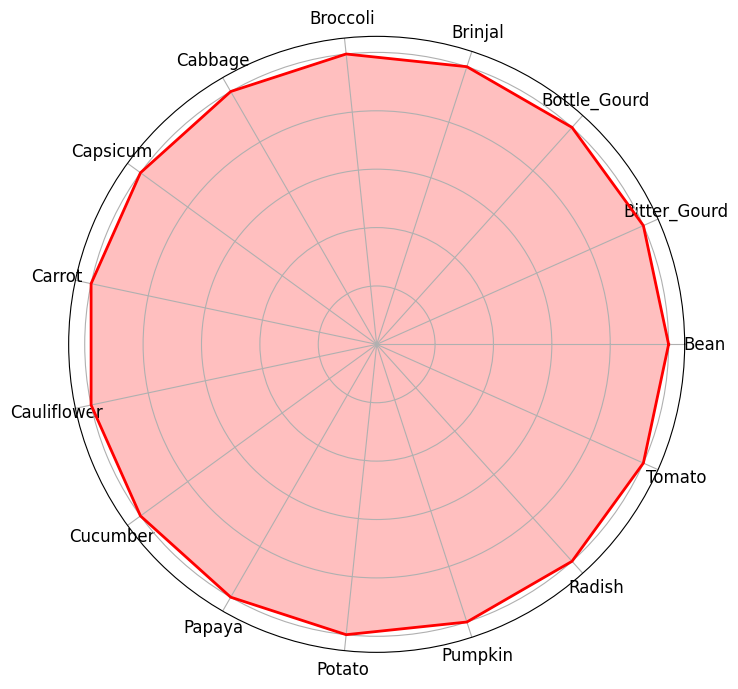

In [8]:
def plot_radar_chart(labels, lb):
    label_names = lb.classes_
    label_counts = np.sum(labels, axis=0)
    angles = np.linspace(0, 2 * np.pi, len(label_names), endpoint=False).tolist()
    label_counts = np.concatenate((label_counts,[label_counts[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.fill(angles, label_counts, color='red', alpha=0.25)
    ax.plot(angles, label_counts, color='red', linewidth=2)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(label_names, fontsize=12)
    plt.show()

plot_radar_chart(train_labels, lb)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(train_images)

# Method 1

In [10]:
import csv
import numpy as np
import pandas as pd
from contextlib import redirect_stdout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the model architecture
def build_custom_cnn(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Initializing the model
IMG_SIZE = 224
input_shape = (IMG_SIZE, IMG_SIZE, 3)
num_classes = 15
model = build_custom_cnn(input_shape, num_classes)

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Method 2

In [11]:
# def build_custom_cnn(input_shape, num_classes):
#     model = Sequential()
#     model.add(Conv2D(128, (3, 3), input_shape=input_shape))
#     model.add(LeakyReLU(alpha=0.1))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Conv2D(64, (3, 3)))
#     model.add(ELU(alpha=1.0))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Conv2D(32, (3, 3)))
#     model.add(LeakyReLU(alpha=0.1))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Flatten())
#     model.add(Dense(32))
#     model.add(ELU(alpha=1.0))
#     model.add(Dropout(0.4))
#     model.add(Dense(num_classes, activation='softmax'))
#     return model

# # Initializing the model
# IMG_SIZE = 224
# input_shape = (IMG_SIZE, IMG_SIZE, 3)
# num_classes = 15
# model = build_custom_cnn(input_shape, num_classes)

# # Compiling the model
# model.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])

# Method 3

In [12]:
# def build_custom_cnn(input_shape, num_classes):
#     model = Sequential()
#     model.add(Conv2D(32, (3, 3), input_shape=input_shape))
#     model.add(LeakyReLU(alpha=0.1))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Conv2D(64, (3, 3)))
#     model.add(ELU(alpha=1.0))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Conv2D(128, (3, 3)))
#     model.add(LeakyReLU(alpha=0.1))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Conv2D(128, (3, 3)))
#     model.add(LeakyReLU(alpha=0.1))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Flatten())
#     model.add(Dense(128))
#     model.add(ELU(alpha=1.0))
#     model.add(Dropout(0.4))
#     model.add(Dense(num_classes, activation='softmax'))
#     return model

# # Initializing the model
# IMG_SIZE = 224
# input_shape = (IMG_SIZE, IMG_SIZE, 3)
# num_classes = 15
# model = build_custom_cnn(input_shape, num_classes)

# # Compiling the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Define callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5)
]

# Train the model
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    validation_data=(val_images, val_labels),
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - accuracy: 0.0625 - loss: 2.8701   

I0000 00:00:1726236955.269035      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1726236955.291246      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.2830 - loss: 2.1171

W0000 00:00:1726237111.492140      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 172s 338ms/step - accuracy: 0.2834 - loss: 2.1158 - val_accuracy: 0.6030 - val_loss: 1.1828 - learning_rate: 0.0010
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 149s 313ms/step - accuracy: 0.5462 - loss: 1.3316 - val_accuracy: 0.7550 - val_loss: 0.7143 - learning_rate: 0.0010
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 149s 312ms/step - accuracy: 0.6277 - loss: 1.0765 - val_accuracy: 0.8457 - val_loss: 0.5030 - learning_rate: 0.0010
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 149s 313ms/step - accuracy: 0.7067 - loss: 0.8891 - val_accuracy: 0.8900 - val_loss: 0.4108 - learning_rate: 0.0010
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 149s 314ms/step - accuracy: 0.7429 - loss: 0.7896 - val_accuracy: 0.8690 - val_loss: 0.4125 - learning_rate: 0.0010
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 148s 311ms/step - accuracy: 0.7677 - loss: 0.7341 - val_accuracy: 0.8793 - val_loss: 0.3784 - learning_rate: 0.0010
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 149s 312ms/step - accuracy: 0.8006 

13/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

W0000 00:00:1726244471.412018      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


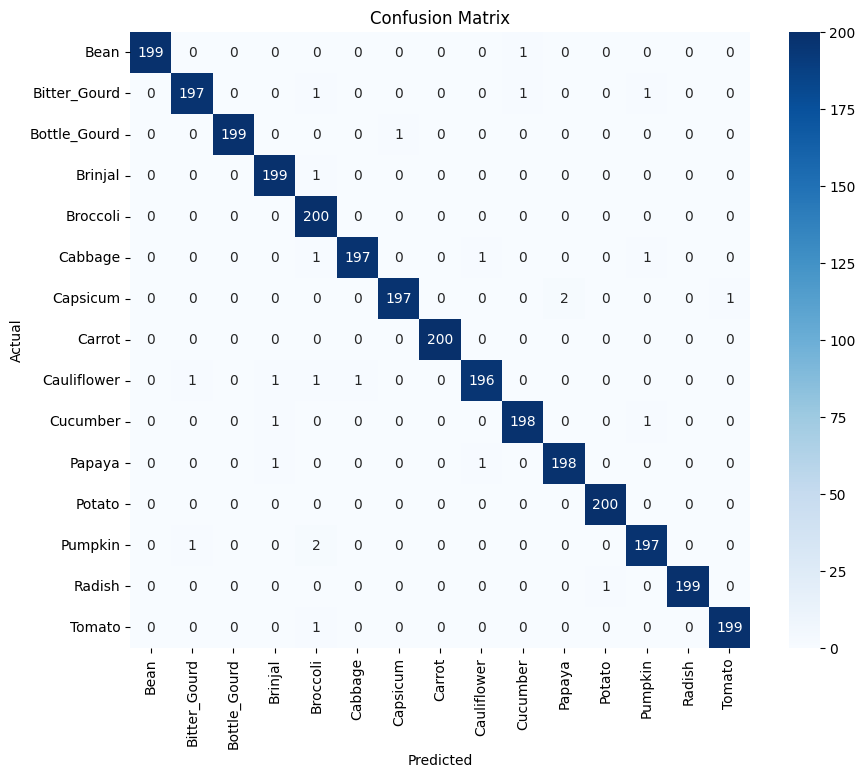

              precision    recall  f1-score   support

        Bean       1.00      0.99      1.00       200
Bitter_Gourd       0.99      0.98      0.99       200
Bottle_Gourd       1.00      0.99      1.00       200
     Brinjal       0.99      0.99      0.99       200
    Broccoli       0.97      1.00      0.98       200
     Cabbage       0.99      0.98      0.99       200
    Capsicum       0.99      0.98      0.99       200
      Carrot       1.00      1.00      1.00       200
 Cauliflower       0.99      0.98      0.98       200
    Cucumber       0.99      0.99      0.99       200
      Papaya       0.99      0.99      0.99       200
      Potato       1.00      1.00      1.00       200
     Pumpkin       0.98      0.98      0.98       200
      Radish       1.00      0.99      1.00       200
      Tomato       0.99      0.99      0.99       200

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99   

In [14]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_labels, pred_labels)
plot_confusion_matrix(cm, lb.classes_)
print(classification_report(true_labels, pred_labels, target_names=lb.classes_))

In [15]:
# Save model summary to CSV
def save_model_summary_to_csv(model, filename):
    with open(filename, 'w') as f:
        with redirect_stdout(f):
            model.summary()

# Save layer configurations to CSV
def save_layer_configurations_to_csv(model, filename):
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Layer Name', 'Output Shape', 'Number of Parameters', 'Stride', 'Padding'])
        for layer in model.layers:
            if isinstance(layer, (Conv2D, MaxPooling2D)):
                writer.writerow([layer.name, layer.output.shape, layer.count_params(), layer.strides, layer.padding])
            else:
                writer.writerow([layer.name, layer.output.shape, layer.count_params(), 'N/A', 'N/A'])

# Save predictions to CSV
def save_predictions_to_csv(predictions, filename):
    predictions_df = pd.DataFrame(predictions)
    predictions_df.to_csv(filename, index=False)

# Save training history to CSV
def save_training_history_to_csv(history, filename):
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(filename, index=False)

# Save the model summary and layer configurations
save_model_summary_to_csv(model, 'model_summary.csv')
save_layer_configurations_to_csv(model, 'layer_configurations.csv')

# Save predictions and training history to CSV
predictions = model.predict(test_images)
save_predictions_to_csv(predictions, 'predictions.csv')
save_training_history_to_csv(history, 'training_history.csv')

# Save the entire model
model.save('trained_model.h5')
print("All output files have been saved!!!")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,512,687 (127.84 MB)

 Trainable params: 11,170,895 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,341,792 (85.23 MB)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
All output files have been saved!!!
